# Computing the mutual information between the environment and the cellular response

In [6]:
# Our numerical workhorses
import numpy as np
import scipy.optimize
import scipy.special
import scipy.integrate
from sympy import mpmath

# Import libraries to parallelize processes
from joblib import Parallel, delayed

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Import pickle to save data
import pickle

# Seaborn, useful for graphics
import seaborn as sns

# Import the utils for this project
import evolution_bits_utils as evo_utils

# favorite Seaborn settings for notebooks
rc={'lines.linewidth': 2, 
    'axes.labelsize' : 16, 
    'axes.titlesize' : 18,
    'axes.facecolor' : 'F4F3F6',
    'axes.edgecolor' : '000000',
    'axes.linewidth' : 1.2,
    'xtick.labelsize' : 13,
    'ytick.labelsize' : 13,
    'grid.linestyle' : ':',
    'grid.color' : 'a6a6a6'}
sns.set_context(rc=rc)

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

outputdir = '../../output/03_mutual_information/'
figdir = '../../fig/03_mutual_information/'
tmpdir = '../../tmp/'

## Computing the mutual information between environment and gene expression.

With the conditional probability defined theoretically using the chemical master equation approach we can finally tackle the main question of the work!

This probability $P(m \mid C)$ allows us to compute the mutual information between the substrate concentration $ C $ and the gene expression level enconded in the variable $ m $. The mutual information is given by
\begin{equation}
    I(m; C) = \int dC P(C) \int dm P(m \mid C) \log_2 \left[ \frac{P(m \mid C)}{P(m)} \right],
\end{equation}
where the probability $P(m)$ must obey
\begin{equation}
    P(m) = \int dC P(C) P(m \mid C).
\end{equation}

Lets define this function!

In [2]:
def mutual_info(C, mRNA, PC_fun, logPmC_fun, params, cutoff=1E-10):
    '''
    Computes the mutual information between the environment and the gene
    expression level on a grid of values of C and mRNA.
    
    Parameters
    ----------
    C : array-like.
        discretized values of the concentration at which the numerical
        integral will be evaluated.
    mRNA : array-like.
        values of the mRNA copy number at which the numerical
        integral will be evaluated.
    PC_fun : function.
        function to determine the probability distribution of each of the
        elements of C. 
        NOTE: When applied to C it must return an array of the same
        length.
    logPmC_fun : function.
        function to determine the conditional distribution logP(m|C). This in 
        general will be one of the versions of the chemical master equation
        solutions, but it can be extended to any input-outpu function one
        wants to use.
        NOTE: When applied to C and mRNA it must return an array of the same
        length.
    params : dictionary.
        dictionary containing all the parameters to compute the mRNA 
        distribution with the chemical-master equations approach.
        the parameters are:
        rep : float.
            repressor copy number per cell.
        ka, ki : float.
            dissociation constants for the active and inactive states 
            respectively in the MWC model of the lac repressor.
        omega : float.
            energetic barrier between the inactive and the active state.
        kon : float.
            rate of activation of the promoter in the chemical master equation.
        k0 : float.
            diffusion limited rate of a repressor binding the promoter
        gamma : float.
            half-life time for the mRNA.
        r_gamma : float.
            average number of mRNA in the unregulated promoter.
    cutoff : float.
        necessary lower bound to determine when to ignore a term in the
        integral given the convention that 0 x log0 = 0.
    
    Returns
    -------
    The mutual information between the gene expession and the environment
    distribution in bits.
    '''
    # Since we'll need 2D integrals, make a mesh of variables
    CC, mm = np.meshgrid(C, mRNA)
    
    # Build P(m|C)
    PmC = np.exp(logPmC_fun(CC, mm, **params)).astype(float)

    # Build P(C)
    PC = PC_fun(C).astype(float)
    
    # Build P(m) by integrating P(C) * P(m|C) over C.
    Pm = scipy.integrate.simps(PC * PmC, x=C, axis=1).astype(float)
    Pm_tile = np.tile(Pm, (len(C), 1)).T

    # Make P(m|C) * log(P(m|C)) making sure no log(0).
    PmC_log_PmC = np.zeros_like(PmC)
    PmC_log_PmC[PmC > cutoff] = PmC[PmC > cutoff] * np.log2(PmC[PmC > cutoff])
    
    # Make P(m|C) * log(P(m)) making sure no log(0).
    PmC_log_Pm = np.zeros_like(PmC)
    PmC_log_Pm[Pm_tile > cutoff] = \
            PmC[Pm_tile > cutoff] * np.log2(Pm_tile[Pm_tile > cutoff])
    
    # Integrate over m
    #int_m = \
    #scipy.integrate.simps(PmC_log_PmC - PmC_log_Pm, x=mRNA, axis=0).astype(float)
    # Since the distribution over mRNA is discrete we have to do a simple sum
    # rather than a numerical integration over m
    int_m = np.sum(PmC_log_PmC - PmC_log_Pm, axis=0).astype(float)
    
    # Return integral over C
    return scipy.integrate.simps(PC * int_m, x=C).astype(float)

### Environment uniform distribution.

Let's first assume a uniform distribution over the different concentrations.

In [3]:
def PC_unif(C):
    '''
    Returns a uniform PDF for an array C. Properly since it is a continuous
    variable the probability should be zero, but since we will be using Simpson's
    rule for numerical integration this funciton returns a numerical value > 0
    for P(C = c).
    
    Parameter
    ---------
    C : array-like.
        Concentrations at which evaluate the function
        
    Returns
    -------
    P(C) : array-like.
        evaluation of the PDF at each discrete point.
    '''
    return np.repeat(1 / (C.max() - C.min()), len(C))

Now let's set the parameters to evalute the mutual information. We will not include the repressor copy number since we will evaluate the mutual information for different values of this parameter.

In [4]:
# Specify some parameters
mastereq_param = dict(ki=0.0012, ka=0.015, omega=1.1, kon=0.0069, 
              k0=2.7e-3, gamma=0.00284, r_gamma=15.7)

Let's determine the integration grids and compute the mutual information!

In [5]:
# Define the grid on which integrate
C_grid = np.linspace(0, 5, 50)
# mRNA_grid = np.arange(0, np.floor(mastereq_param['r_gamma'] * 1.7))
mRNA_grid = np.arange(0, 100)

compute_MI = True
if compute_MI:
    # define the array of repressor copy numbers to evaluate the function in
    R_array = [0, 10, 100, 1000]
    MI_array = np.zeros_like(R_array)
    for i, r in enumerate(R_array):
        mastereq_param['rep'] = r
        MI_array[i] = \
        mutual_info(C=C_grid, mRNA=mRNA_grid, 
                    PC_fun=PC_unif, logPmC_fun=evo_utils.log_p_m_mid_C,
                    params=mastereq_param).astype(float)

In [6]:
MI_array

array([0, 0, 0, 0])

For some reason I do not fully understand when assuming this distribution for the environments the integration fails to give a reasonable value. Must have to do with the range of values I am choosing.
I will come back to this issue later.

### $\log$ environment uniform distribution

A simple alternative is to assume that
\begin{equation}
    \log C \sim Unif \left[ \log C_{\min} , \log C_{\max} \right].
\end{equation}

Then we just calculate the mutual information as follows
\begin{equation}
    I(\log C; m) = \int d\log C \; P(\log C) \int dm \; P(m \mid \log C) \log \frac{P(m \mid \log C)}{P(m)},
\end{equation}
where
\begin{equation}
    P(m) = \int d \log C \; P(\log C) P(m \mid \log C).
\end{equation}

In [4]:
def PlogC_unif(logC):
    '''
    Returns a uniform PDF for an array logC. Properly since it is a continuous
    variable the probability should be zero, but since we will be using Simpson's
    rule for numerical integration this funciton returns a numerical value > 0
    for P(logC = logc).
    
    Parameter
    ---------
    logC : array-like.
        Concentrations at which evaluate the function
        
    Returns
    -------
    P(C) : array-like.
        evaluation of the PDF at each discrete point.
    '''
    return np.repeat(1 / (logC.max() - logC.min()), len(logC))

In [9]:
# Specify some parameters
mastereq_param = dict(ki=0.0012, ka=0.015, omega=1.1, kon=0.0069, 
              k0=2.7e-3, gamma=0.00284, r_gamma=15.7)

### [$10^{-3}$ mM, $1$ mM]

In [10]:
# Define the grid on which integrate
logC_grid = np.linspace(-3, 0, 100)
# mRNA_grid = np.arange(0, np.floor(mastereq_param['r_gamma'] * 1.7))
mRNA_grid = np.arange(0, 100)

# define the array of repressor copy numbers to evaluate the function in
R_array = np.logspace(0, 3, 40)

compute_MI = True
if compute_MI:
# define a function to run in parallel the computation
    def MI_parallel(r):
        mastereq_param['rep'] = r
        return mutual_info(C=logC_grid, mRNA=mRNA_grid, 
        PC_fun=PlogC_unif, logPmC_fun=evo_utils.log_p_m_mid_logC,
        params=mastereq_param)
    MI_array = Parallel(n_jobs=6)(delayed(MI_parallel)(r) for r in R_array)
    
    # To be consistent and have reproducible results we will save the following:
    # 1. the mutual information array
    # 2. the repressor array
    # 3. the concentration array
    # 4. the mRNA array
    pklfile = open(outputdir + 'MI_rgamma10_logunif_1E-3mM_1mM.pkl', 'wb')
    pickle.dump(MI_array, pklfile)
    pickle.dump(R_array, pklfile)
    pickle.dump(mastereq_param, pklfile)
    pickle.dump(logC_grid, pklfile)
    pickle.dump(mRNA_grid, pklfile)

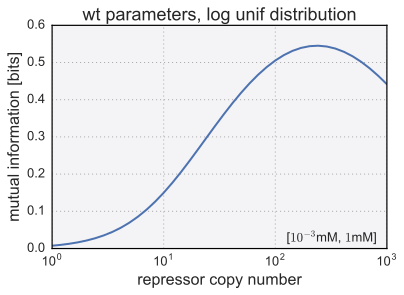

In [12]:
pklfile = open(outputdir + 'MI_rgamma10_logunif_1E-3mM_1mM.pkl', 'rb')
MI_array = pickle.load(pklfile)
R_array = pickle.load(pklfile)

with sns.axes_style('darkgrid', rc=rc):
    fig = plt.figure()
    ax = plt.subplot(111)
    _ = ax.plot(R_array, MI_array)
    ax.set_xscale('log')
    ax.set_xlabel('repressor copy number')
    ax.set_ylabel('mutual information [bits]')
    ax.set_title('wt parameters, log unif distribution')
    # indicate the concentration range used for the calculation
    ax.text(0.7, 0.05, r'[$10^{-3}$mM, $1$mM]',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes, fontsize=13)
plt.savefig(figdir + 'MI_rgamma10_logunif_1E-3mM_1mM.pdf')

### [$10^{-6}$ mM, $1$ mM]

In [13]:
# Define the grid on which integrate
logC_grid = np.linspace(-6, 0, 100)
# mRNA_grid = np.arange(0, np.floor(mastereq_param['r_gamma'] * 1.7))
mRNA_grid = np.arange(0, 100)

# define the array of repressor copy numbers to evaluate the function in
R_array = np.logspace(0, 3, 40)

compute_MI = True
if compute_MI:
# define a function to run in parallel the computation
    def MI_parallel(r):
        mastereq_param['rep'] = r
        return mutual_info(C=logC_grid, mRNA=mRNA_grid, 
        PC_fun=PlogC_unif, logPmC_fun=evo_utils.log_p_m_mid_logC,
        params=mastereq_param)
    MI_array = Parallel(n_jobs=6)(delayed(MI_parallel)(r) for r in R_array)
    
    # To be consistent and have reproducible results we will save the following:
    # 1. the mutual information array
    # 2. the repressor array
    # 3. the concentration array
    # 4. the mRNA array
    pklfile = open(outputdir + 'MI_rgamma10_logunif_1E-6mM_1mM.pkl', 'wb')
    pickle.dump(MI_array, pklfile)
    pickle.dump(R_array, pklfile)
    pickle.dump(logC_grid, pklfile)
    pickle.dump(mRNA_grid, pklfile)

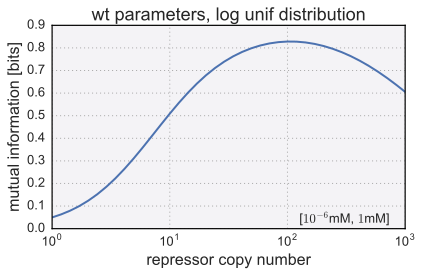

In [14]:
pklfile = open(outputdir + 'MI_rgamma10_logunif_1E-6mM_1mM.pkl', 'rb')
MI_array = pickle.load(pklfile)
R_array = pickle.load(pklfile)

with sns.axes_style(rc=rc):
    fig = plt.figure()
    ax = plt.subplot(111)
    _ = ax.plot(R_array, MI_array)
    ax.set_xscale('log')
    ax.set_xlabel('repressor copy number')
    ax.set_ylabel('mutual information [bits]')
    ax.set_title('wt parameters, log unif distribution')
    # indicate the concentration range used for the calculation
    ax.text(0.7, 0.05, r'[$10^{-6}$mM, $1$mM]',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes, fontsize=13)
plt.tight_layout()
plt.savefig(figdir + 'MI_rgamma10_logunif_1E-6mM_1mM.pdf')

### Exponential distribution of environments.

In his paper Bialek mentions that they assume a probability distribution for the environments of the form
\begin{equation}
    P(C) \propto \exp (- 2 C).
\end{equation}

So let's try computing the mutual information using this distribution. In general wi will say
\begin{equation}
    P(C) = \tau \exp (- \tau C),
\end{equation}
where $\mathbf{E}(C) = \frac{1}{\tau}$

In [5]:
def PC_expo(C, tau=2):
    '''
    Returns an exponential PDF for an array C. Properly since it is a 
    continuous variable the probability should be zero, but since we 
    will be using Simpson's rule for numerical integration this funciton 
    returns a numerical value > 0 for P(C = c).
    
    Parameter
    ---------
    C : array-like.
        concentrations at which evaluate the function
        
    Returns
    -------
    P(C) : array-like.
        evaluation of the PDF at each discrete point.
    '''
    return tau * np.exp(- tau * C)

### $\tau = 2$,  [$10^{-8}$ mM, $5$ mM]

In [16]:
# Define the grid on which integrate
C_grid = np.linspace(1E-8, 5, 100)
# mRNA_grid = np.arange(0, np.floor(mastereq_param['r_gamma'] * 1.7))
mRNA_grid = np.arange(0, 100)

# define the array of repressor copy numbers to evaluate the function in
R_array = np.logspace(0, 3, 40)

compute_MI = True
if compute_MI:
# define a function to run in parallel the computation
    def MI_parallel(r):
        mastereq_param['rep'] = r
        return mutual_info(C=C_grid, mRNA=mRNA_grid, 
        PC_fun=PC_expo, logPmC_fun=evo_utils.log_p_m_mid_C,
        params=mastereq_param)
    MI_array = Parallel(n_jobs=6)(delayed(MI_parallel)(r) for r in R_array)
    
    # To be consistent and have reproducible results we will save the following:
    # 1. the mutual information array
    # 2. the repressor array
    # 3. the concentration array
    # 4. the mRNA array
    pklfile = open(outputdir + 'MI_param_WT_expo_2_1E-8mM_5mM.pkl', 'wb')
    pickle.dump(MI_array, pklfile)
    pickle.dump(R_array, pklfile)
    pickle.dump(logC_grid, pklfile)
    pickle.dump(mRNA_grid, pklfile)

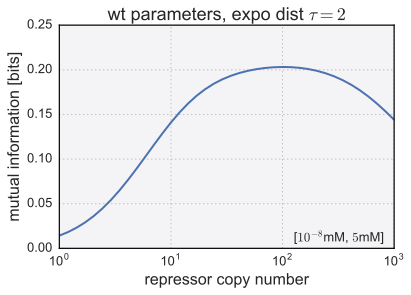

In [17]:
pklfile = open(outputdir + 'MI_param_WT_expo_2_1E-8mM_5mM.pkl', 'rb')
MI_array = pickle.load(pklfile)
R_array = pickle.load(pklfile)

with sns.axes_style(rc=rc):
    fig = plt.figure()
    ax = plt.subplot(111)
    _ = ax.plot(R_array, MI_array)
    ax.set_xscale('log')
    ax.set_xlabel('repressor copy number')
    ax.set_ylabel('mutual information [bits]')
    ax.set_title(r'wt parameters, expo dist $\tau = 2$')
    # indicate the concentration range used for the calculation
    ax.text(0.7, 0.05, r'[$10^{-8}$mM, $5$mM]',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes, fontsize=13)
plt.savefig(figdir + 'MI_param_WT_expo_2_1E-8mM_5mM.pdf')

### $\tau = 4$,  [$10^{-8}$ mM, $5$ mM]

In [18]:
# Define the grid on which integrate
C_grid = np.linspace(1E-8, 5, 100)
# mRNA_grid = np.arange(0, np.floor(mastereq_param['r_gamma'] * 1.7))
mRNA_grid = np.arange(0, 100)

# define the array of repressor copy numbers to evaluate the function in
R_array = np.logspace(0, 3, 40)

# define a lambda function to change the value of the parameter tau
# while still be able to feed it to the function
PC_tmp = lambda C: PC_expo(C, 4)

compute_MI = True
if compute_MI:
# define a function to run in parallel the computation
    def MI_parallel(r):
        mastereq_param['rep'] = r
        return mutual_info(C=C_grid, mRNA=mRNA_grid, 
        PC_fun=PC_tmp, logPmC_fun=evo_utils.log_p_m_mid_C,
        params=mastereq_param)
    MI_array = Parallel(n_jobs=6)(delayed(MI_parallel)(r) for r in R_array)
    
    # To be consistent and have reproducible results we will save the following:
    # 1. the mutual information array
    # 2. the repressor array
    # 3. the concentration array
    # 4. the mRNA array
    pklfile = open(outputdir + 'MI_param_WT_expo_4_1E-8mM_5mM.pkl', 'wb')
    pickle.dump(MI_array, pklfile)
    pickle.dump(R_array, pklfile)
    pickle.dump(logC_grid, pklfile)
    pickle.dump(mRNA_grid, pklfile)

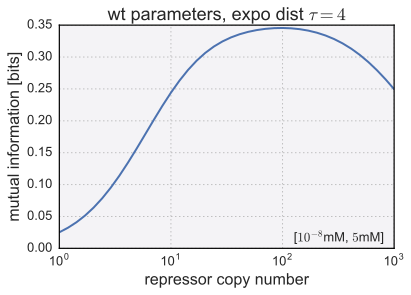

In [21]:
pklfile = open(outputdir + 'MI_param_WT_expo_4_1E-8mM_5mM.pkl', 'rb')
MI_array = pickle.load(pklfile)
R_array = pickle.load(pklfile)

with sns.axes_style(rc=rc):
    fig = plt.figure()
    ax = plt.subplot(111)
    _ = ax.plot(R_array, MI_array)
    ax.set_xscale('log')
    ax.set_xlabel('repressor copy number')
    ax.set_ylabel('mutual information [bits]')
    ax.set_title(r'wt parameters, expo dist $\tau = 4$')
    # indicate the concentration range used for the calculation
    ax.text(0.7, 0.05, r'[$10^{-8}$mM, $5$mM]',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes, fontsize=13)
    plt.savefig(figdir + 'MI_param_WT_expo_4_1E-8mM_5mM.pdf')

### $\tau = 10$,  [$10^{-8}$ mM, $5$ mM]

In [20]:
# Define the grid on which integrate
C_grid = np.linspace(1E-8, 5, 100)
# mRNA_grid = np.arange(0, np.floor(mastereq_param['r_gamma'] * 1.7))
mRNA_grid = np.arange(0, 100)
# define the array of repressor copy numbers to evaluate the function in
R_array = np.logspace(0, 3, 40)

# define a lambda function to change the value of the parameter tau
# while still be able to feed it to the function
PC_tmp = lambda C: PC_expo(C, 10)

compute_MI = True
if compute_MI:
# define a function to run in parallel the computation
    def MI_parallel(r):
        mastereq_param['rep'] = r
        return mutual_info(C=C_grid, mRNA=mRNA_grid, 
        PC_fun=PC_tmp, logPmC_fun=evo_utils.log_p_m_mid_C,
        params=mastereq_param)
    MI_array = Parallel(n_jobs=6)(delayed(MI_parallel)(r) for r in R_array)
    
    # To be consistent and have reproducible results we will save the following:
    # 1. the mutual information array
    # 2. the repressor array
    # 3. the concentration array
    # 4. the mRNA array
    pklfile = open(outputdir + 'MI_param_WT_expo_10_1E-8mM_5mM.pkl', 'wb')
    pickle.dump(MI_array, pklfile)
    pickle.dump(R_array, pklfile)
    pickle.dump(logC_grid, pklfile)
    pickle.dump(mRNA_grid, pklfile)

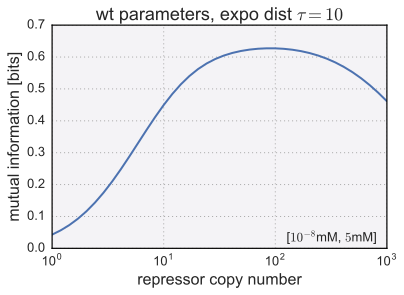

In [22]:
pklfile = open(outputdir + 'MI_param_WT_expo_10_1E-8mM_5mM.pkl', 'rb')
MI_array = pickle.load(pklfile)
R_array = pickle.load(pklfile)

with sns.axes_style(rc=rc):
    fig = plt.figure()
    ax = plt.subplot(111)
    _ = ax.plot(R_array, MI_array)
    ax.set_xscale('log')
    ax.set_xlabel('repressor copy number')
    ax.set_ylabel('mutual information [bits]')
    ax.set_title(r'wt parameters, expo dist $\tau = 10$')
    # indicate the concentration range used for the calculation
    ax.text(0.7, 0.05, r'[$10^{-8}$mM, $5$mM]',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes, fontsize=13)
plt.savefig(figdir + 'MI_param_WT_expo_10_1E-8mM_5mM.pdf')

### Uniform distribution over the $\log$ concentration, but integrate over the linear scale.

Last but not least let's assume that again $\log C \sim Unif[C_\min, C_\max]$. But this time we will integrate over C rather than over $\log C$.

By a simple change of variables we can obtain this PDF
\begin{equation}
    f_C(c) = f_{\log C}(\log C) \lvert \frac{d \log C}{d C} \lvert.
\end{equation}
This gives us that the PDF for the concentration when it is uniformly distributed over log scale is given by
\begin{equation}
    f_C(C) = \frac{1}{C (\log C_{\max} - \log C_{\min})}, \forall C \in [\exp \log C_{\min}, \exp \log C_{\min}].
\end{equation}

In [21]:
def PC_log_unif(C):
    '''
    Returns a PDF for an array C on which log C is uniformly distributed. 
    Properly since it is a continuous variable the probability should be zero, 
    but since we will be using Simpson's rule for numerical integration this
    funciton returns a numerical value > 0 for P(C = c).
    
    Parameter
    ---------
    logC : array-like.
        log_10 concentrations at which evaluate the function
        
    Returns
    -------
    P(C) : array-like.
        evaluation of the PDF at each discrete point.
    '''
    return 1 / C / (np.log(C).max() - np.log(C).min())

In [25]:
# Define the grid on which integrate
logC_grid = np.linspace(-5, 1, 100)
mRNA_grid = np.arange(0, np.floor(mastereq_param['r_gamma'] * 1.7))

# define the array of repressor copy numbers to evaluate the function in
R_array = np.logspace(0, 3, 40)

compute_MI = True
if compute_MI:
# define a function to run in parallel the computation
    def MI_parallel(r):
        mastereq_param['rep'] = r
        return mutual_info(C=np.power(10, logC_grid), mRNA=mRNA_grid, 
        PC_fun=PC_log_unif, logPmC_fun=evo_utils.log_p_m_mid_C,
        params=mastereq_param)
    MI_array = Parallel(n_jobs=6)(delayed(MI_parallel)(r) for r in R_array)
    np.savetxt('../../tmp/MI_param_WT_C_log_unif.txt', MI_array)

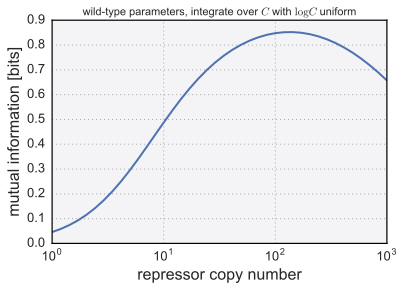

In [27]:
MI_array = np.loadtxt('../../tmp/MI_param_WT_C_log_unif.txt').flatten()
with sns.axes_style(rc=rc):
    plt.plot(R_array, MI_array)
    plt.xscale('log')
    plt.xlabel('repressor copy number')
    plt.ylabel('mutual information [bits]')
    plt.title('wild-type parameters, integrate over $C$ with $\log C$ uniform',
             fontsize=11)

Great! the fact that this is equal to the calculation we did with $I(\log C; m)$ confirms that it doesn't matter if we calculate the mutual information with respect to the $\log$ of the concentration or with the concentration itself since $\log$ is a one-to-one function and mutual information is invariant to these type of transformations.

# Arcsine distribution

An interesting bimodal distribution that we want to explore is the so-called arcsine distribution. This distribution has a PDF defined as
\begin{equation}
    P(C) = \frac{1}{\pi \sqrt{(C - C_\min)(C_\max - C)}},
\end{equation}
where $C_\min$ and $C_\max$ are the minimum and maximum concentrations allowed.

The idea for using this distribution came from a further down script where we calculate the channel capacity of the communication channel and the distribution that achieves capacity seems to be multimodal with high probability at low and at high concentrations.

In [24]:
def PC_arcsine(C):
    '''
    Returns an arsine PDF for an array C. Properly since it is a 
    continuous variable the probability should be zero, but since we 
    will be using Simpson's rule for numerical integration this funciton 
    returns a numerical value > 0 for P(C = c).
    
    Parameter
    ---------
    C : array-like.
        concentrations at which evaluate the function
        
    Returns
    -------
    P(C) : array-like.
        evaluation of the PDF at each discrete point.
    '''
    return 1 / (np.pi * np.sqrt((C - C.min()) * (C.max() - C)))

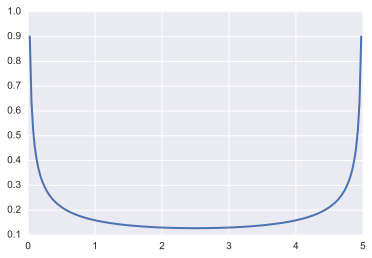

In [25]:
C_grid = np.linspace(0, 5, 200)
_ = plt.plot(C_grid, PC_arcsine(C_grid))

In [21]:
scipy.integrate.simps(PC_arcsine(C_grid), x=C_grid)

inf

In [9]:
# Specify some parameters
mastereq_param = dict(ki=0.0012, ka=0.015, omega=1.1, kon=0.0069, 
              k0=2.7e-3, gamma=0.00284, r_gamma=15.7)

# Define the grid on which integrate
C_grid = np.linspace(0, 5, 200)
mRNA_grid = np.linspace(0, 100, 201)

# define the array of repressor copy numbers to evaluate the function in
R_array = np.logspace(0, 3, 3)

compute_MI = True
if compute_MI:
# define a function to run in parallel the computation
    def MI_parallel(r):
        mastereq_param['rep'] = r
        return mutual_info(C=C_grid, mRNA=mRNA_grid, 
        PC_fun=PC_arcsine, logPmC_fun=evo_utils.log_p_m_mid_C,
        params=mastereq_param)
    MI_array = Parallel(n_jobs=1)(delayed(MI_parallel)(r) for r in R_array)
    
    # To be consistent and have reproducible results we will save the following:
    # 1. the mutual information array
    # 2. the repressor array
    # 3. the concentration array
    # 4. the mRNA array
    pklfile = open(outputdir + 'MI_param_WT_arcsine_0mM_5mM.pkl', 'wb')
    pickle.dump(MI_array, pklfile)
    pickle.dump(R_array, pklfile)
    pickle.dump(C_grid, pklfile)
    pickle.dump(mRNA_grid, pklfile)
    pklfile.close()

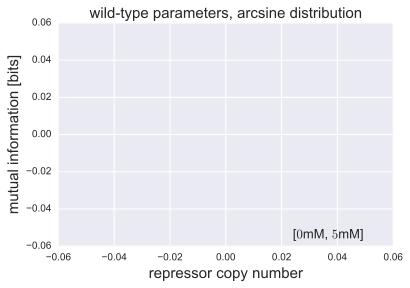

In [12]:
pklfile = open(outputdir + 'MI_param_WT_arcsine_0mM_5mM.pkl', 'rb')
MI_array = pickle.load(pklfile)
R_array = pickle.load(pklfile)
pklfile.close()

fig = plt.figure()
ax = plt.subplot(111)
_ = ax.plot(R_array, MI_array)
ax.set_xlabel('repressor copy number')
ax.set_ylabel('mutual information [bits]')
ax.set_title(r'wild-type parameters, arcsine distribution')
# indicate the concentration range used for the calculation
ax.text(0.7, 0.05, r'[$0$mM, $5$mM]',
        horizontalalignment='left',
        verticalalignment='center',
        transform=ax.transAxes, fontsize=13)

# Spectral integration.

One can greatly reduce the number of grid points you use without sacrificing accuracy by using **spectral integration**.

The key idea here is to sample the function at Chebyshev points and then use Clenshaw-Curtis weights to perform the quadrature.  Below are utility functions to do that.

(Credit to Justin Bois)

In [39]:
def cheb_points_1d(n, xends=[-1.0, 1.0]):
    """
    Computes Chebyshev points for a 1-D Chebyshev grid, returned as ndarray.
    
    xends specifies the end points of the array.
    """
    
    x = np.cos(np.pi * np.array(np.arange(n)) / (n-1))
    x = (xends[1] - xends[0]) / 2.0 * x + (xends[1] + xends[0]) / 2.0

    return x


def clenshaw_curtis_weights(n):
    """
    Computes the weights to be applied in Curtis-Clenshaw integration,
    sampling at n assuming Chebyshev points.

    Adapted from Nick Trefethen's book: Spectral Methods in Matlab
    """

    n -= 1  # This is to stay consistent with our indexing

    theta = np.pi * np.arange(n+1) / n
    w = np.zeros_like(theta)
    v = np.ones(n-1)
    if n % 2 == 0:
        w[0] = 1.0 / (n**2 - 1)
        w[-1] = w[0]
        for k in range(1, n//2):
            v -= 2.0 * np.cos(2.0 * k * theta[1:-1]) / (4.0 * k**2 - 1)
        v -= np.cos(n * theta[1:-1]) / (n**2 - 1)
    else:
        w[0] = 1.0 / n**2
        w[-1] = w[0]
        for k in range(1, (n-1)//2 + 1):
            v -= 2.0 * np.cos(2.0 * k * theta[1:-1]) / (4.0 * k**2 - 1)

    w[1:-1] = 2.0 * v / n

    return w


def cheb_quad(y, w, domain_size):
    """
    Perform spectral integration given Clenshaw-Curtis weights. The
    weights are computed from clenshaw_curtis_weights().  
    """
    return np.dot(w, y) * domain_size / 2

With these function, we can make new grid points and perform the integration.

In [52]:
def mutual_info_spectral(C_range, mRNA, PC_fun, logPmC_fun, params,
                         n_points=64, cutoff=1E-10):
    '''
    Computes the mutual information between the environment and the gene
    expression level on a grid of values of C and mRNA.
    
    Parameters
    ----------
    C_range : array-like.
        range of concentrations that should be taken for the integration.
        For spectral integration we just give the range because the grid points
        at which the integral is evaluated are computed with Chebyshev's formula.
    mRNA : array-like.
        discretized values of the mRNA copy number at which the numerical
        integral will be evaluated.
    PC_fun : function.
        function to determine the probability distribution of each of the
        elements of C. 
        NOTE: Should return n_points between C_range.min() and C_range.max()
    logPmC_fun : function.
        function to determine the conditional distribution logP(m|C). This in 
        general will be one of the versions of the chemical master equation
        solutions, but it can be extended to any input-outpu function one
        wants to use.
        NOTE: When applied to C and mRNA it must return an array of the same
        length.
    params : dictionary.
        dictionary containing all the parameters to compute the mRNA 
        distribution with the chemical-master equations approach.
        the parameters are:
        rep : float.
            repressor copy number per cell.
        ka, ki : float.
            dissociation constants for the active and inactive states 
            respectively in the MWC model of the lac repressor.
        omega : float.
            energetic barrier between the inactive and the active state.
        kon : float.
            rate of activation of the promoter in the chemical master equation.
        k0 : float.
            diffusion limited rate of a repressor binding the promoter
        gamma : float.
            half-life time for the mRNA.
        r_gamma : float.
            average number of mRNA in the unregulated promoter.
    n_points : int.
        number of grid points used for the spectral integration. This is the 
        number of Chebyshev points that are used for the integration.
    cutoff : float.
        necessary lower bound to determine when to ignore a term in the
        integral given the convention that 0 x log0 = 0.
    
    Returns
    -------
    The mutual information between the gene expession and the environment
    distribution in bits.
    '''
    # Convert C_range into a numpy array
    C_range = np.array(C_range)
    # Set the Chebyshev points and the Clenshaw curtis weights
    C_cheb= cheb_points_1d(n_points, [C_range.min(), C_range.max()])
    w = clenshaw_curtis_weights(n_points)
    
    # Since we'll need 2D integrals, make a mesh of variables
    CC, mm = np.meshgrid(C_cheb, mRNA)
    
    # Build P(m|C)
    PmC = np.exp(logPmC_fun(CC, mm, **params)).astype(float)

    # Build P(C)
    PC = PC_fun(C_cheb).astype(float) 
    # Build P(m) by integrating P(C) * P(m|C) over C.
    Pm = cheb_quad((PC * PmC).T, w, C_cheb.max()-C_cheb.min()).astype(float)
    Pm_tile = np.tile(Pm, (n_points, 1)).T

    # Make P(m|C) * log(P(m|C)) making sure no log(0).
    PmC_log_PmC = np.zeros_like(PmC)
    PmC_log_PmC[PmC > cutoff] = PmC[PmC > cutoff] * np.log2(PmC[PmC > cutoff])
    
    # Make P(m|C) * log(P(m)) making sure no log(0).
    PmC_log_Pm = np.zeros_like(PmC)
    PmC_log_Pm[Pm_tile > cutoff] = \
            PmC[Pm_tile > cutoff] * np.log2(Pm_tile[Pm_tile > cutoff])
    
    # Integrate over m.
    # NOTE: since the distribution is only normalized for discrete values, we
    # actually sum over the values rather than integrating
    int_m = \
    np.sum(PmC_log_PmC - PmC_log_Pm, axis=0).astype(float)

    # Return integral over C
    return cheb_quad(PC * int_m, w, C_cheb.max()-C_cheb.min()).astype(float)

## Comparison between regular numerical integration and spectral integration.

Now that we implemented the spectral integration lets compare it with the regular one.

In [63]:
# Specify some parameters
mastereq_param = dict(ki=0.0012, ka=0.015, omega=1.1, kon=0.0069, 
              k0=2.7e-3, gamma=0.00284, r_gamma=15.7)

# Define the grid on which integrate
C_grid = np.linspace(0, 5, 200)
C_range = np.array([C_grid.max(), C_grid.min()])
mRNA_grid = np.arange(0, 50)
mastereq_param['rep'] = 10

In [61]:
print('Regular integration:')
%timeit mutual_info(C=C_grid, mRNA=mRNA_grid, PC_fun=PC_expo, logPmC_fun=evo_utils.log_p_m_mid_C, params=mastereq_param)
print('Spectral integration:')
%timeit mutual_info_spectral(C_range=C_range, mRNA=mRNA_grid, PC_fun=PC_expo, logPmC_fun=evo_utils.log_p_m_mid_C, params=mastereq_param)

Regular integration:
1 loop, best of 3: 2.47 s per loop
Spectral integration:
1 loop, best of 3: 777 ms per loop


In [66]:
mutual_info(C=C_grid, mRNA=mRNA_grid, PC_fun=PC_expo, 
            logPmC_fun=evo_utils.log_p_m_mid_C, params=mastereq_param) - \
mutual_info_spectral(C_range=C_range, mRNA=mRNA_grid, 
                     PC_fun=PC_expo, logPmC_fun=evo_utils.log_p_m_mid_C, 
                     params=mastereq_param, n_points=64)

0.062710998477379418

In [67]:
# Define the grid on which integrate
logC_grid = np.linspace(-6, 0, 200)
logC_range = np.array([logC_grid.max(), logC_grid.min()])
mRNA_grid = np.arange(0, np.floor(mastereq_param['r_gamma'] * 1.7))

# define the array of repressor copy numbers to evaluate the function in
R_array = np.logspace(0, 3, 40)

compute_MI = True
if compute_MI:
# define a function to run in parallel the computation
    def MI_parallel(r):
        mastereq_param['rep'] = r
        return mutual_info_spectral(C_range=logC_range, mRNA=mRNA_grid, 
        PC_fun=PlogC_unif, logPmC_fun=evo_utils.log_p_m_mid_logC,
        params=mastereq_param)
    MI_array = Parallel(n_jobs=6)(delayed(MI_parallel)(r) for r in R_array)
    
    # To be consistent and have reproducible results we will save the following:
    # 1. the mutual information array
    # 2. the repressor array
    # 3. the concentration array
    # 4. the mRNA array
    pklfile = open(outputdir + 'MI_rgamma10_logunif_1E-6mM_1mM_spectral.pkl', 
                   'wb')
    pickle.dump(MI_array, pklfile)
    pickle.dump(R_array, pklfile)
    pickle.dump(logC_grid, pklfile)
    pickle.dump(mRNA_grid, pklfile)

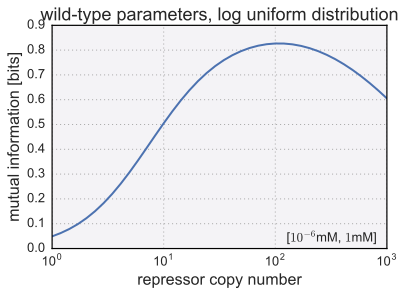

In [68]:
pklfile = open(outputdir + 'MI_rgamma10_logunif_1E-6mM_1mM_spectral.pkl', 'rb')
MI_array = pickle.load(pklfile)
R_array = pickle.load(pklfile)

with sns.axes_style(rc=rc):
    fig = plt.figure()
    ax = plt.subplot(111)
    _ = ax.plot(R_array, MI_array)
    ax.set_xscale('log')
    ax.set_xlabel('repressor copy number')
    ax.set_ylabel('mutual information [bits]')
    ax.set_title('wild-type parameters, log uniform distribution')
    # indicate the concentration range used for the calculation
    ax.text(0.7, 0.05, r'[$10^{-6}$mM, $1$mM]',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes, fontsize=13)
#plt.savefig(figdir + 'MI_rgamma10_logunif_1E-6mM_1mM.pdf')

The plot looks exactly the same! I can't even believe it. Let's take a look on how different the values obtained with both integration procedures are.

In [70]:
pklfile = open(outputdir + 'MI_rgamma10_logunif_1E-6mM_1mM_spectral.pkl', 'rb')
MI_spectral = pickle.load(pklfile)

pklfile = open(outputdir + 'MI_rgamma10_logunif_1E-6mM_1mM.pkl', 'rb')
MI_simps = pickle.load(pklfile)

np.array(MI_spectral) - np.array(MI_simps)

array([  3.00713128e-10,   3.81172621e-10,   4.79775344e-10,
         5.99269856e-10,   7.42331627e-10,   9.11378945e-10,
         1.10837481e-09,   1.33464925e-09,   1.59079439e-09,
         1.87666993e-09,   2.19154739e-09,   2.53436316e-09,
         2.90403357e-09,   3.29976102e-09,   3.72131537e-09,
         4.16929602e-09,   4.64541494e-09,   5.15277476e-09,
         5.69606218e-09,   6.28152075e-09,   6.91660995e-09,
         7.60934338e-09,   8.36241598e-09,   9.18418053e-09,
         1.01732117e-08,   1.11127751e-08,   1.21723363e-08,
         1.33108278e-08,   1.45676428e-08,   1.55980021e-08,
         1.70741253e-08,   1.84796242e-08,   1.97058623e-08,
         2.11820990e-08,   2.23857638e-08,   2.36506886e-08,
         2.49200428e-08,   2.61260146e-08,   2.73129239e-08,
         2.82370647e-08])

This is amazing! Spectral integration is super fast. All of my computations of mutual information just got speed up by a factor of three.